In [140]:
import numpy as np
import pandas as pd

# -----------------------------
# 1. BASIC SIMULATION SETTINGS
# -----------------------------
np.random.seed(42)

DAYS = 30
PERIODS_PER_DAY = 96      # 15-minute resolution
H = DAYS * PERIODS_PER_DAY
DT = 0.25                 # hours per time slot (15 minutes)

NUM_CONSUMERS = 3
NUM_PROSUMERS = 7
N = NUM_CONSUMERS + NUM_PROSUMERS

# ---------------------------------------------------
# 2. HELPER: CREATE TIME INDEX & HOUSEHOLD LABELS
# ---------------------------------------------------
time_index = pd.date_range("2025-01-01", periods=H, freq="15min")

household_ids = []
household_types = []   # "consumer" or "prosumer"

for i in range(NUM_CONSUMERS):
    household_ids.append(f"C{i+1}")
    household_types.append("consumer")

for j in range(NUM_PROSUMERS):
    household_ids.append(f"P{j+1}")
    household_types.append("prosumer")

household_ids = np.array(household_ids)
household_types = np.array(household_types)

# -----------------------------
# Heterogeneous grid tariffs
# -----------------------------
lambda_buy_individual = np.zeros(N)
lambda_sell_individual = np.zeros(N)

for i in range(N):
    if household_types[i] == "consumer":
        # Slightly higher / residential slab
        lambda_buy_individual[i] = np.random.uniform(6.0, 7.0)
        lambda_sell_individual[i] = 0.0   # no PV; export irrelevant
    else:
        # Prosumer: maybe special net-metering category
        lambda_buy_individual[i] = np.random.uniform(5.0, 6.0)
        lambda_sell_individual[i] = np.random.uniform(3.0, 3.8)

# Global "reference" tariffs for the microgrid / MMR formulas
LAMBDA_BUY_REF = np.mean(lambda_buy_individual)
# use only prosumers for sell reference
LAMBDA_SELL_REF = np.mean(lambda_sell_individual[lambda_sell_individual > 0])

# ---------------------------------------------------
# 3. LOAD PROFILE GENERATION (AVERAGE INDIAN HOMES)
# ---------------------------------------------------
def generate_daily_load_shape(periods_per_day=PERIODS_PER_DAY, dt=DT):
    """
    Create a generic 1-day load shape with morning & evening peaks.
    Returns an array of kW values (relative shape, not scaled to kWh).
    """
    t = np.arange(periods_per_day)
    hours = t * dt

    # Base: low at night, higher in evening
    base = 0.2  # constant background load like fridge, fan, etc.
    morning_peak = np.exp(-0.5 * ((hours - 8) / 1.5) ** 2)  # This is a Gaussian curve centered at 8 AM, width ~1.5 hours.
    evening_peak = 1.3 * np.exp(-0.5 * ((hours - 20) / 2.0) ** 2)   # This is a Gaussian curve centered at 8 PM, width ~2 hours.

    shape = base + 0.7 * morning_peak + 1.0 * evening_peak  # baseline + small bump + big bump
    shape = np.maximum(shape, 0.05)  # avoid zero
    return shape    # [PERIODS_PER_DAY, 1]

def generate_household_loads(num_consumers, num_prosumers,
                             days=DAYS, periods_per_day=PERIODS_PER_DAY, dt=DT):
    """
    Generate L[N, H] load matrix (kW) for all households.
    Consumers: ~4–7 kWh/day
    Prosumers: ~5–9 kWh/day (slightly higher)
    """
    N = num_consumers + num_prosumers
    H = days * periods_per_day
    shape_day = generate_daily_load_shape(periods_per_day, dt)

    # precompute day-normalization
    shape_energy_per_day = np.sum(shape_day * dt)  # kWh/day per unit scale

    L = np.zeros((N, H))

    for idx in range(N):
        is_prosumer = (idx >= num_consumers)

        if is_prosumer:
            target_kwh_day = np.random.uniform(5.0, 9.0)
        else:
            target_kwh_day = np.random.uniform(4.0, 7.0)

        scale = target_kwh_day / shape_energy_per_day
        base_profile = shape_day * scale  # one-day profile in kW

        # Tile across days with small day-to-day variation
        for d in range(days):
            day_noise_factor = np.random.normal(1.0, 0.05)  # ±5%
            noise = np.random.normal(0.0, 0.05, size=periods_per_day)  # local fluctuations

            profile_day = base_profile * day_noise_factor * (1.0 + noise)
            profile_day = np.clip(profile_day, 0.05, None)  # avoid negative

            start = d * periods_per_day
            end = (d + 1) * periods_per_day
            L[idx, start:end] = profile_day

    return L

# ---------------------------------------------------
# 4. PV GENERATION FOR PROSUMERS (TIED TO LOAD)
# ---------------------------------------------------
def generate_daily_pv_shape(periods_per_day=PERIODS_PER_DAY, dt=DT):
    """
    Clear-sky PV power shape (kW per kWp) peaking at noon.
    """
    t = np.arange(periods_per_day)
    hours = t * dt

    # Simple sine-shaped irradiance between 6:00 and 18:00
    angle = np.pi * (hours - 6) / 12.0
    irradiance = np.sin(angle)
    irradiance[irradiance < 0] = 0.0

    return irradiance

def generate_pv_profiles_from_load(L, num_consumers, num_prosumers,
                                   days=DAYS, periods_per_day=PERIODS_PER_DAY, dt=DT):
    """
    Generate PV[N,H] matrix (kW) where prosumer PV size is chosen
    relative to their own load.

    Steps:
      - For each prosumer, compute avg daily load (kWh/day).
      - Choose a PV sizing factor f in [0.4, 1.1], meaning:
            daily_pv_energy ≈ f * daily_load_energy
        -> some prosumers undersized, some near 1:1, some slightly oversized.
      - Assume PV yield ~ 4.5–5.5 kWh/kWp/day.
      - Solve for capacity_kWp = (f * daily_load) / (yield_per_kwp).
      - Build PV profile using a clear-sky shape + randomness.
    """
    N, H = L.shape
    assert N == num_consumers + num_prosumers
    assert H == days * periods_per_day

    pv_shape = generate_daily_pv_shape(periods_per_day, dt)
    # Energy per kWp per day from shape (kWh/kWp/day)
    shape_energy_per_day_per_kwp = np.sum(pv_shape * dt)

    PV = np.zeros((N, H))

    for idx in range(N):
        if idx < num_consumers:
            # Consumers have no PV
            continue

        # 1) Compute this prosumer's average daily load (kWh/day)
        total_load_kwh = np.sum(L[idx, :] * dt)
        avg_daily_load_kwh = total_load_kwh / days

        # 2) Choose sizing factor: PV daily energy ≈ factor * daily load
        #    -> mix of undersized (0.4–0.8) and slightly oversized (0.8–1.1)
        sizing_factor = np.random.uniform(0.4, 1.5)

        target_pv_kwh_day = sizing_factor * avg_daily_load_kwh

        # 3) Assume realistic PV yield per kWp (kWh/kWp/day)
        yield_per_kwp = np.random.uniform(4.5, 5.5)

        # capacity in kWp needed to hit the target daily energy
        # target_pv_kwh_day ≈ capacity_kwp * yield_per_kwp
        capacity_kwp = target_pv_kwh_day / yield_per_kwp

        # 4) Scale clear-sky shape to this capacity
        # shape gives kW per kWp; multiply by capacity
        base_profile_kw = pv_shape * capacity_kwp * (yield_per_kwp / shape_energy_per_day_per_kwp)

        for d in range(days):
            # Weather variation / clouds
            cloud_factor = np.random.normal(1.0, 0.15)  # ±15%
            noise = np.random.normal(0.0, 0.05, size=periods_per_day)

            profile_day = base_profile_kw * cloud_factor * (1.0 + noise)
            profile_day = np.clip(profile_day, 0.0, None)

            start = d * periods_per_day
            end = (d + 1) * periods_per_day
            PV[idx, start:end] = profile_day

    return PV


In [141]:
def compute_cp2p_dynamic(L_total, PV_total,
                         lambda_buy_ref, lambda_sell_ref, eps=1e-9):
    """
    Compute cp2p[h] between sell and buy price depending on net balance.
    net = (L - PV)/(L + PV) in [-1,1]
      net = -1 -> huge surplus -> cp2p ~ lambda_sell
      net =  0 -> balanced     -> cp2p ~ midpoint
      net = +1 -> huge shortage-> cp2p ~ lambda_buy
    """
    H = len(L_total)
    cp2p = np.zeros(H)
    mid = 0.5 * (lambda_buy_ref + lambda_sell_ref)
    spread = 0.5 * (lambda_buy_ref - lambda_sell_ref)

    for h in range(H):
        denom = L_total[h] + PV_total[h]
        if denom < eps:
            cp2p[h] = mid
            continue
        net = (L_total[h] - PV_total[h]) / denom  # in [-1,1]
        cp2p[h] = mid + spread * net

    return cp2p

In [142]:
L = generate_household_loads(NUM_CONSUMERS, NUM_PROSUMERS)
PV = generate_pv_profiles_from_load(L, NUM_CONSUMERS, NUM_PROSUMERS)

N_total = L.shape[0]
H = L.shape[1]

L_reshaped = L.reshape(N_total, DAYS, PERIODS_PER_DAY)
PV_reshaped = PV.reshape(N_total, DAYS, PERIODS_PER_DAY)

# --------------------------------------------------------------
# STEP 0: Baseline – keep PV modest for everyone
#         => for most prosumers, PV <= 80% of their own daily load
# --------------------------------------------------------------
for i in range(N_total):
    for d in range(DAYS):
        load_day = L_reshaped[i, d].sum() * DT   # kWh/day
        pv_day   = PV_reshaped[i, d].sum() * DT
        if load_day <= 0 or pv_day <= 0:
            continue

        max_ratio = 0.8   # PV <= 80% of daily load for typical prosumer
        if pv_day > max_ratio * load_day:
            scale = (max_ratio * load_day) / pv_day
            PV_reshaped[i, d] *= scale

# --------------------------------------------------------------
# STEP 1: Pick a few exporters and boost their PV
#         => these guys will often have PV > load
# --------------------------------------------------------------
exporters = [NUM_CONSUMERS + 0, NUM_CONSUMERS + 1]   # normal exporters
super_exporter = NUM_CONSUMERS + 2                   # slightly bigger exporter

for i in exporters + [super_exporter]:
    for d in range(DAYS):
        load_day = L_reshaped[i, d].sum() * DT
        pv_day   = PV_reshaped[i, d].sum() * DT
        if load_day <= 0 or pv_day <= 0:
            continue

        # small oversizing so community is still net importer overall
        target_ratio = 1.1 if i in exporters else 1.5   # super exporter a bit higher

        if pv_day < target_ratio * load_day:
            scale = (target_ratio * load_day) / pv_day
            PV_reshaped[i, d] *= scale

# Back to [agent, time] shape
PV = PV_reshaped.reshape(N_total, H)

# -----------------------------
# Random events (same as before)
# -----------------------------
num_inverter_events = 2
for _ in range(num_inverter_events):
    prosumer_local_idx = np.random.randint(0, NUM_PROSUMERS)
    prosumer_idx = NUM_CONSUMERS + prosumer_local_idx

    day = np.random.randint(0, DAYS)
    start = day * PERIODS_PER_DAY
    end = (day + 1) * PERIODS_PER_DAY

    PV[prosumer_idx, start:end] = 0.0   # inverter out all day

H = L.shape[1]
p2p_allowed = np.ones(H, dtype=bool)

num_maintenance_events = 3
slots_per_event = 8   # 2 hours

for _ in range(num_maintenance_events):
    start_slot = np.random.randint(0, H - slots_per_event)
    end_slot = start_slot + slots_per_event
    p2p_allowed[start_slot:end_slot] = False


In [143]:
def settle_conventional_timeseries(L, PV, dt,
                                   lambda_buy_individual, lambda_sell_individual):
    """
    Each household:
      - Self-consumes min(L, PV) for free
      - Net import from grid at its own lambda_buy_i
      - Net export to grid at its own lambda_sell_i
    Returns:
      bills[N], cost_ts[N,H]
    """
    N, H = L.shape
    M = np.minimum(L, PV)
    residual_import = np.maximum(L - M, 0.0)
    residual_export = np.maximum(PV - M, 0.0)

    cost_ts = np.zeros((N, H))
    for i in range(N):
        cost_ts[i, :] = (residual_import[i, :] * dt * lambda_buy_individual[i] -
                         residual_export[i, :] * dt * lambda_sell_individual[i])

    bills = np.sum(cost_ts, axis=1)
    return bills, cost_ts

In [144]:
bills_conv, cost_ts_conv = settle_conventional_timeseries(
    L, PV, DT, lambda_buy_individual, lambda_sell_individual
)

In [145]:
def settle_mmr_timeseries(L, PV, dt,
                          lambda_buy_ref, lambda_sell_ref,
                          p2p_allowed, epsilon=1e-6):
    """
    Mid-market rate with dynamic cp2p[h].
    Uses reference grid tariffs (not per-household hetero) for simplicity.
    """
    N, H = L.shape
    L_total = np.sum(L, axis=0)
    PV_total = np.sum(PV, axis=0)

    # dynamic cp2p per slot
    cp2p = compute_cp2p_dynamic(L_total, PV_total,
                                lambda_buy_ref, lambda_sell_ref)

    Pim = np.zeros_like(L)
    Pex = np.zeros_like(L)
    for h in range(H):
        for i in range(N):
            M_ih = min(L[i, h], PV[i, h])
            Pim[i, h] = L[i, h] - M_ih
            Pex[i, h] = PV[i, h] - M_ih

    c_im = np.zeros(H)
    c_ex = np.zeros(H)
    for h in range(H):
        if not p2p_allowed[h]:
            # "No P2P advantage" -> just grid prices
            c_im[h] = lambda_buy_ref
            c_ex[h] = lambda_sell_ref
            continue

        if abs(PV_total[h] - L_total[h]) <= epsilon:
            c_im[h] = cp2p[h]
            c_ex[h] = cp2p[h]
        elif PV_total[h] > L_total[h]:
            c_im[h] = cp2p[h]
            if PV_total[h] > 0:
                c_ex[h] = (L_total[h] * cp2p[h] +
                           (PV_total[h] - L_total[h]) * lambda_sell_ref) / PV_total[h]
            else:
                c_ex[h] = lambda_sell_ref
        else:
            c_ex[h] = cp2p[h]
            if L_total[h] > 0:
                c_im[h] = (PV_total[h] * cp2p[h] +
                           (L_total[h] - PV_total[h]) * lambda_buy_ref) / L_total[h]
            else:
                c_im[h] = lambda_buy_ref

    cost_ts = np.zeros((N, H))
    for i in range(N):
        for h in range(H):
            e_im = Pim[i, h] * dt
            e_ex = Pex[i, h] * dt
            cost_ts[i, h] += e_im * c_im[h]
            cost_ts[i, h] -= e_ex * c_ex[h]

    bills = np.sum(cost_ts, axis=1)
    return bills, cost_ts, c_im, c_ex, cp2p


In [146]:
bills_mmr, cost_ts_mmr, c_im_mmr, c_ex_mmr, cp2p_ts = settle_mmr_timeseries(
    L, PV, DT, LAMBDA_BUY_REF, LAMBDA_SELL_REF, p2p_allowed
)

In [147]:
def settle_bill_sharing_timeseries(L, PV, dt,
                                   lambda_buy_individual, lambda_sell_individual,
                                   lambda_buy_ref, lambda_sell_ref,
                                   p2p_allowed):
    """
    Bill-sharing P2P:
      - P2P trades at cp2p[h] (dynamic)
      - Residual imports/exports with grid at each agent's own tariff
      - When p2p_allowed[h] is False -> cp2p[h] energy = 0 (all via grid)
    """
    N, H = L.shape
    L_total = np.sum(L, axis=0)
    PV_total = np.sum(PV, axis=0)

    cp2p = compute_cp2p_dynamic(L_total, PV_total,
                                lambda_buy_ref, lambda_sell_ref)

    Pim = np.zeros_like(L)
    Pex = np.zeros_like(L)
    for h in range(H):
        for i in range(N):
            M_ih = min(L[i, h], PV[i, h])
            Pim[i, h] = L[i, h] - M_ih
            Pex[i, h] = PV[i, h] - M_ih

    cost_ts = np.zeros((N, H))

    for h in range(H):
        import_tot = np.sum(Pim[:, h])
        export_tot = np.sum(Pex[:, h])

        if import_tot <= 0 and export_tot <= 0:
            continue

        if not p2p_allowed[h]:
            # No P2P this slot: everything with grid at individual tariffs
            for i in range(N):
                e_im = Pim[i, h] * dt
                e_ex = Pex[i, h] * dt
                cost_ts[i, h] += e_im * lambda_buy_individual[i]
                cost_ts[i, h] -= e_ex * lambda_sell_individual[i]
            continue

        # P2P allowed
        p2p_energy = min(import_tot, export_tot)
        p2p_import_fraction = p2p_energy / import_tot if import_tot > 0 else 0.0
        p2p_export_fraction = p2p_energy / export_tot if export_tot > 0 else 0.0

        for i in range(N):
            e_im = Pim[i, h] * dt
            e_ex = Pex[i, h] * dt

            e_im_p2p = Pim[i, h] * p2p_import_fraction * dt if import_tot > 0 else 0.0
            e_ex_p2p = Pex[i, h] * p2p_export_fraction * dt if export_tot > 0 else 0.0

            e_im_grid = e_im - e_im_p2p
            e_ex_grid = e_ex - e_ex_p2p

            # P2P at cp2p[h]
            cost_ts[i, h] += e_im_p2p * cp2p[h]
            cost_ts[i, h] -= e_ex_p2p * cp2p[h]

            # Grid residual at individual tariffs
            cost_ts[i, h] += e_im_grid * lambda_buy_individual[i]
            cost_ts[i, h] -= e_ex_grid * lambda_sell_individual[i]

    bills = np.sum(cost_ts, axis=1)
    return bills, cost_ts, cp2p


In [148]:
bills_bs, cost_ts_bs, cp2p_bs_ts = settle_bill_sharing_timeseries(
    L, PV, DT,
    lambda_buy_individual, lambda_sell_individual,
    LAMBDA_BUY_REF, LAMBDA_SELL_REF,
    p2p_allowed
)

In [149]:
def settle_sdr_timeseries(L, PV, dt,
                          lambda_buy_ref, lambda_sell_ref,
                          p2p_allowed, epsilon=1e-9):
    """
    SDR-based P2P pricing (no demand response, just current L & PV):
      - Buyers: NP = L - PV > 0
      - Sellers: NP < 0
      - SDR = TSP / TBP
      - Prices follow SDR rules from the internship algorithm pdf:
          * Shortage (0 <= SDR < 1):
                Pr_sell = (λ_buy * λ_sell) / ((λ_buy - λ_sell)*SDR + λ_sell)
                Pr_buy  = Pr_sell * SDR + λ_buy * (1 - SDR)
          * Surplus (SDR >= 1 or TBP = 0):
                Pr_sell = Pr_buy = λ_sell
      - Internal P2P energy is min(TSP, TBP) and is shared
        proportionally among buyers/sellers.
      - Remainder goes to / comes from the grid at λ_buy_ref / λ_sell_ref.
    Returns:
      bills[N],
      cost_ts[N,H],
      Pr_buy[H],
      Pr_sell[H],
      SDR[H]
    """
    N, H = L.shape
    NP = L - PV  # +ve: buyer, -ve: seller

    # Grid imports/exports
    Pim = np.zeros_like(L)   # power from grid
    Pex = np.zeros_like(L)   # power to grid

    # P2P trades (energy, but we store as power; multiply by dt in costs)
    Pp2p_buy = np.zeros_like(L)   # power bought from community
    Pp2p_sell = np.zeros_like(L)  # power sold to community

    TSP = np.zeros(H)
    TBP = np.zeros(H)
    SDR = np.zeros(H)
    Pr_buy = np.zeros(H)
    Pr_sell = np.zeros(H)

    for h in range(H):
        # If P2P is not allowed, fall back to grid-only (like conventional)
        if not p2p_allowed[h]:
            for i in range(N):
                if NP[i, h] > 0:
                    Pim[i, h] = NP[i, h]
                elif NP[i, h] < 0:
                    Pex[i, h] = -NP[i, h]
            SDR[h] = np.nan
            Pr_buy[h] = lambda_buy_ref
            Pr_sell[h] = lambda_sell_ref
            continue

        buyers = NP[:, h] > 0
        sellers = NP[:, h] < 0

        TBP[h] = NP[buyers, h].sum() if np.any(buyers) else 0.0
        TSP[h] = (-NP[sellers, h]).sum() if np.any(sellers) else 0.0

        if TBP[h] <= epsilon:
            SDR[h] = np.inf
        else:
            SDR[h] = TSP[h] / TBP[h]

        # --- SDR-based pricing ---
        if not np.isfinite(SDR[h]) or SDR[h] >= 1.0:
            # Surplus: collapse to feed-in tariff
            Pr_sell[h] = lambda_sell_ref
            Pr_buy[h] = lambda_sell_ref
        else:
            SDRh = SDR[h]
            # Shortage case pricing (from pdf)
            Pr_sell[h] = (lambda_buy_ref * lambda_sell_ref) / (
                (lambda_buy_ref - lambda_sell_ref) * SDRh + lambda_sell_ref
            )
            Pr_buy[h] = Pr_sell[h] * SDRh + lambda_buy_ref * (1.0 - SDRh)

        # --- Allocate internal P2P energy ---
        internal_power = min(TSP[h], TBP[h])  # kW

        if internal_power > 0:
            # Sellers share the internal sale proportional to their surplus
            if TSP[h] > 0 and np.any(sellers):
                seller_surplus = -NP[sellers, h]  # positive
                Pp2p_sell[sellers, h] = internal_power * seller_surplus / TSP[h]

            # Buyers share the internal purchase proportional to their deficit
            if TBP[h] > 0 and np.any(buyers):
                buyer_deficit = NP[buyers, h]  # positive
                Pp2p_buy[buyers, h] = internal_power * buyer_deficit / TBP[h]

        # --- Remaining goes to / from the grid ---
        for i in range(N):
            net = NP[i, h]
            if net > 0:
                # buyer: deficit = net, part met by P2P, rest from grid
                residual = net - Pp2p_buy[i, h]
                Pim[i, h] = max(residual, 0.0)
            elif net < 0:
                # seller: surplus = -net, part sold via P2P, rest to grid
                residual = -net - Pp2p_sell[i, h]
                Pex[i, h] = max(residual, 0.0)

    # --- Cost calculation ---
    cost_ts = np.zeros((N, H))
    for i in range(N):
        for h in range(H):
            # Grid trades
            cost_ts[i, h] += Pim[i, h] * dt * lambda_buy_ref
            cost_ts[i, h] -= Pex[i, h] * dt * lambda_sell_ref

            # P2P trades
            cost_ts[i, h] += Pp2p_buy[i, h] * dt * Pr_buy[h]
            cost_ts[i, h] -= Pp2p_sell[i, h] * dt * Pr_sell[h]

    bills = np.sum(cost_ts, axis=1)
    return bills, cost_ts, Pr_buy, Pr_sell, SDR

In [150]:
bills_sdr, cost_ts_sdr, Pr_buy_sdr, Pr_sell_sdr, SDR_ts = settle_sdr_timeseries(
    L, PV, DT,
    LAMBDA_BUY_REF, LAMBDA_SELL_REF,
    p2p_allowed
)

In [151]:
import matplotlib.pyplot as plt

H = L.shape[1]
day_index = np.arange(H) // PERIODS_PER_DAY  # 0..DAYS-1

# Community total load & PV per slot (kWh)
total_load_per_slot_kwh = np.sum(L, axis=0) * DT
total_pv_per_slot_kwh = np.sum(PV, axis=0) * DT

daily_total_load_kwh = np.bincount(day_index, weights=total_load_per_slot_kwh, minlength=DAYS)
daily_total_pv_kwh = np.bincount(day_index, weights=total_pv_per_slot_kwh, minlength=DAYS)

# Average per household / per prosumer
daily_avg_load_kwh_per_house = daily_total_load_kwh / N
daily_avg_pv_kwh_per_prosumer = daily_total_pv_kwh / NUM_PROSUMERS

# Daily bills: sum cost over all households first, then per day
total_cost_conv_per_slot = np.sum(cost_ts_conv, axis=0)
total_cost_mmr_per_slot = np.sum(cost_ts_mmr, axis=0)
total_cost_bs_per_slot = np.sum(cost_ts_bs, axis=0)
total_cost_sdr_per_slot = np.sum(cost_ts_sdr, axis=0)


daily_bill_conv = np.bincount(day_index, weights=total_cost_conv_per_slot, minlength=DAYS)
daily_bill_mmr = np.bincount(day_index, weights=total_cost_mmr_per_slot, minlength=DAYS)
daily_bill_bs = np.bincount(day_index, weights=total_cost_bs_per_slot, minlength=DAYS)
daily_bill_sdr = np.bincount(day_index, weights=total_cost_sdr_per_slot, minlength=DAYS)

days_arr = np.arange(1, DAYS + 1)

daily_df = pd.DataFrame({
    "day": days_arr,
    "avg_load_kWh_per_house": daily_avg_load_kwh_per_house,
    "avg_pv_kWh_per_prosumer": daily_avg_pv_kwh_per_prosumer,
    "bill_conv_Rs": daily_bill_conv,
    "bill_mmr_Rs": daily_bill_mmr,
    "bill_bs_Rs": daily_bill_bs,
    "bill_sdr_Rs": daily_bill_sdr,   
})
print(daily_df.round(2))


    day  avg_load_kWh_per_house  avg_pv_kWh_per_prosumer  bill_conv_Rs  \
0     1                    7.26                     7.23        216.93   
1     2                    7.20                     6.81        223.57   
2     3                    7.34                     6.94        228.18   
3     4                    7.28                     7.04        224.22   
4     5                    7.39                     7.28        222.55   
5     6                    7.27                     6.56        235.70   
6     7                    7.41                     7.13        227.31   
7     8                    7.45                     7.25        226.31   
8     9                    7.43                     7.08        229.11   
9    10                    7.29                     7.27        217.44   
10   11                    7.39                     6.97        230.44   
11   12                    7.48                     7.41        225.12   
12   13                    7.16       

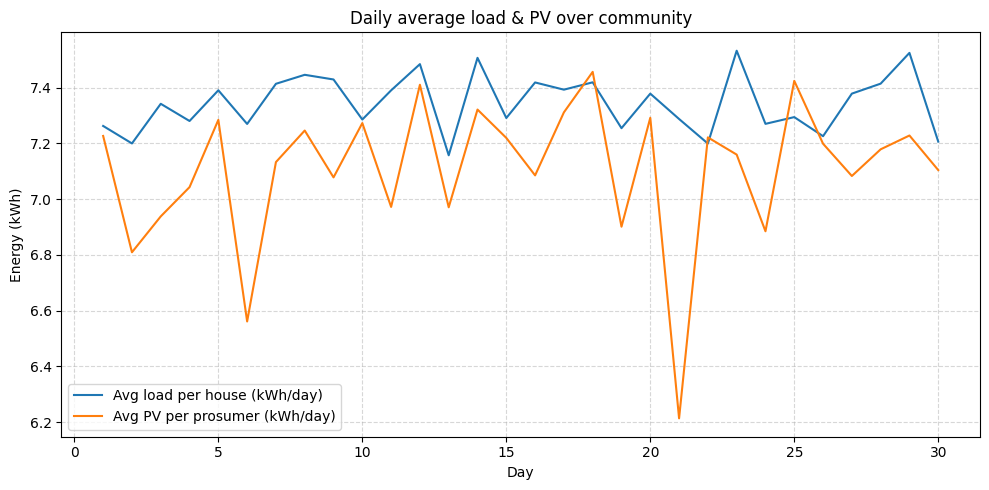

In [152]:
plt.figure(figsize=(10, 5))
plt.plot(days_arr, daily_avg_load_kwh_per_house, label="Avg load per house (kWh/day)")
plt.plot(days_arr, daily_avg_pv_kwh_per_prosumer, label="Avg PV per prosumer (kWh/day)")
plt.xlabel("Day")
plt.ylabel("Energy (kWh)")
plt.title("Daily average load & PV over community")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

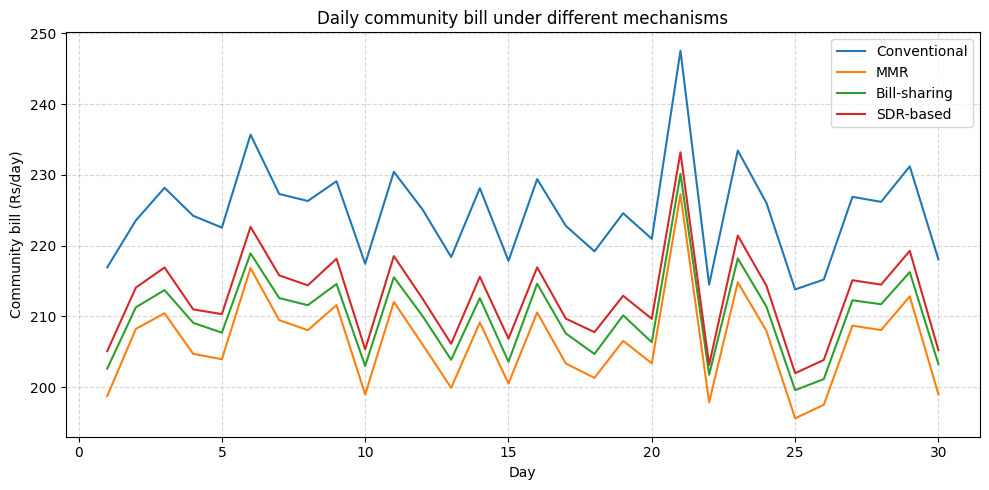

In [153]:
plt.figure(figsize=(10, 5))
plt.plot(days_arr, daily_bill_conv, label="Conventional")
plt.plot(days_arr, daily_bill_mmr, label="MMR")
plt.plot(days_arr, daily_bill_bs, label="Bill-sharing")
plt.plot(days_arr, daily_bill_sdr, label="SDR-based")  # NEW
plt.xlabel("Day")
plt.ylabel("Community bill (Rs/day)")
plt.title("Daily community bill under different mechanisms")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()